# Lab5

C:\Users\marci\AppData\Local\Temp\ipykernel_20292\1958690599.py:43: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  keras_classifier=KerasClassifier(build_model)


Epoch 1/10
36/36 [==============================] - 1s 2ms/step - loss: 2.4537 - accuracy: 0.1088
Epoch 2/10
36/36 [==============================] - 0s 2ms/step - loss: 2.1965 - accuracy: 0.1976
Epoch 3/10
36/36 [==============================] - 0s 2ms/step - loss: 2.0106 - accuracy: 0.3342
Epoch 4/10
36/36 [==============================] - 0s 3ms/step - loss: 1.8471 - accuracy: 0.4508
Epoch 5/10
36/36 [==============================] - 0s 2ms/step - loss: 1.6930 - accuracy: 0.5474
Epoch 6/10
36/36 [==============================] - 0s 2ms/step - loss: 1.5443 - accuracy: 0.6258
Epoch 7/10
36/36 [==============================] - 0s 3ms/step - loss: 1.3999 - accuracy: 0.6893
Epoch 8/10
36/36 [==============================] - 0s 3ms/step - loss: 1.2610 - accuracy: 0.7476
Epoch 9/10
36/36 [==============================] - 0s 2ms/step - loss: 1.1288 - accuracy: 0.7894
Epoch 10/10
9/9 [==============================] - 0s 2ms/step - loss: 0.9967 - accuracy: 0.8125
Epoch 1/10
36/36 [===

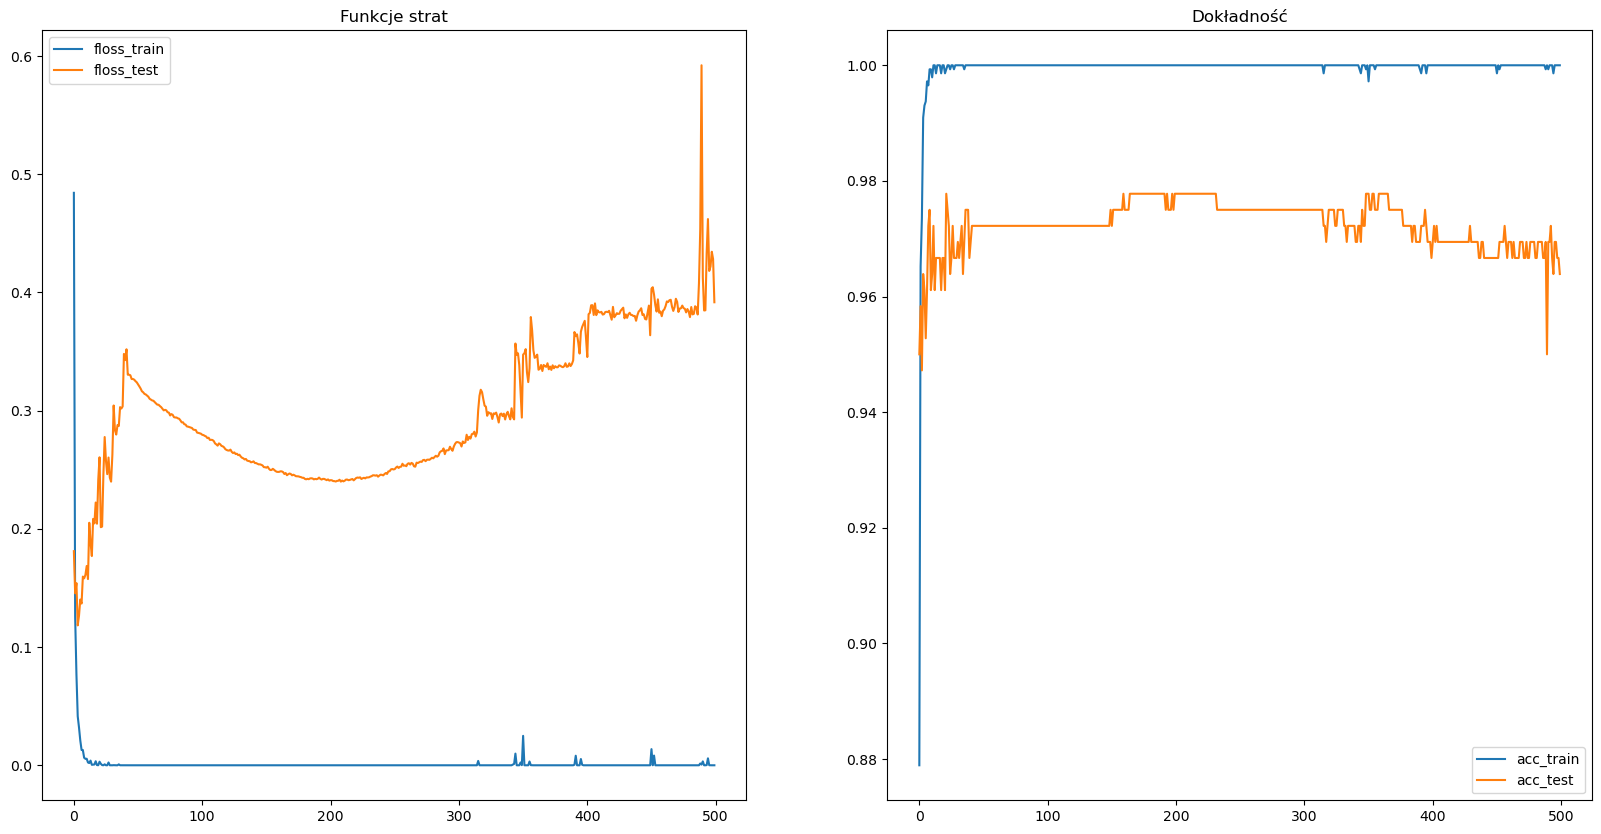

In [1]:
#%% DATA LOADING
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
data = load_digits()
X = data.data
first_y = data.target #Nazwy zmiennych zmienione w celu inspekcji działania funckji
categorical_y = pd.Categorical(first_y)
y = pd.get_dummies(categorical_y).values
class_num = y.shape[1]

#%%MODELS IMPORTS
from keras.wrappers.scikit_learn import KerasClassifier
from scipy.stats import reciprocal
from keras.models import Sequential
from keras.layers import Input, Dense
from keras.optimizers import Adam, RMSprop, SGD
from keras.utils import plot_model
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

#%%DATA SPLIT AND MANIPULATION
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2, random_state=42)
scaler=StandardScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)

#%%BUILDING NEURAL NETWORK
num_epochs_for_search=10
num_epochs_for_final_training = 500
def build_model(n_hidden, n_neurons, learning_rate, activation,optimizer):
    model = Sequential()
    model.add(Dense(n_neurons, input_shape = (X.shape[1],), activation = activation))
    for layer in range(n_hidden):
        model.add(Dense(n_neurons, activation=activation))
    model.add(Dense(class_num, activation='softmax'))
    model.compile(optimizer=optimizer(learning_rate), loss='categorical_crossentropy', metrics=('accuracy'))
    return model    
#%%RANDOMIZED SEARCH -looking for best parameters
keras_classifier=KerasClassifier(build_model)
param_distribs={
    'n_hidden': [0,1,2,3],
    'n_neurons': np.arange(1,100),
    'learning_rate': reciprocal(3e-4, 3e-2),
    'activation': ['relu','selu','softmax'],
    'optimizer': [SGD,Adam,RMSprop]
    }
rnd_search_cv=RandomizedSearchCV(keras_classifier, param_distribs, n_iter=10, cv=5)
rnd_search_cv.fit(X_train, y_train, epochs=num_epochs_for_search)

best_params_from_random=rnd_search_cv.best_params_ 
best_model_from_random=rnd_search_cv.best_estimator_ 

print("Najlepsze parametry: ",best_params_from_random)

for i in range(10,-1,-1):   #Czas na zrobienie screena, wyliczonym parametrom
    print("\rRozpoczęcie trenowania z tymi parametrami za {}  ".format(i),end="")
    time.sleep(1)

#%% CREATION OF BEST NETWORK - based on parameters search
best_model = build_model(best_params_from_random['n_hidden'],best_params_from_random['n_neurons'],
                         best_params_from_random['learning_rate'],best_params_from_random['activation'],
                         best_params_from_random['optimizer'])

best_model.fit(X_train,y_train,batch_size=32,epochs=num_epochs_for_final_training,validation_data=(X_test,y_test),verbose=2)

#%% CHARTS OF MODEL TRAINING HISTORY
history = best_model.history.history
floss_train = history['loss']
floss_test = history['val_loss']
acc_train = history['accuracy']
acc_test = history['val_accuracy']
fig,ax = plt.subplots(1,2, figsize=(20,10))

epochs = np.arange(0, num_epochs_for_final_training)
ax[0].plot(epochs, floss_train, label = 'floss_train')
ax[0].plot(epochs, floss_test, label = 'floss_test')
ax[0].set_title('Funkcje strat')
ax[0].legend()
ax[1].set_title('Dokładność')
ax[1].plot(epochs, acc_train, label = 'acc_train')
ax[1].plot(epochs, acc_test, label = 'acc_test')
ax[1].legend()